In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import time

# Rastgelelik tekrar üretilebilirliği için sabitlenir
# Aynı kod her çalıştırıldığında aynı sonuçların alınması sağlanır (özellikle gürültü ve model eğitimi için önemlidir)
np.random.seed(42)

In [3]:
# MNIST veri seti yüklenir ve 0-1 aralığına normalize edilir
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
veri = mnist.data.astype('float32') / 255.0
etiket = mnist.target.astype('int')

# Eğitim ve test kümeleri ayrıştırılır
X_egitim, X_test, _, _ = train_test_split(veri, etiket, test_size=0.2, random_state=42)
X_egitim = X_egitim.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)

In [4]:
# Görüntüye Gauss tipi gürültü ekleyen yardımcı fonksiyon
def gauss_gurultu_ekle(goruntu, ort=0, std=0.5):
    gurultu = np.random.normal(ort, std, goruntu.shape)
    sonuc = goruntu + gurultu
    return np.clip(sonuc, 0, 1)

In [5]:
# 2B konvolüsyon işlemi (yansımalı kenar doldurma ile)
def konvolusyon_uygula(giris, cekirdek):
    kh, kw = cekirdek.shape
    ph, pw = kh // 2, kw // 2
    giris_pad = np.pad(giris, ((ph, ph), (pw, pw)), mode='reflect')
    cikti = np.zeros_like(giris)

    for satir in range(giris.shape[0]):
        for sutun in range(giris.shape[1]):
            pencere = giris_pad[satir:satir + kh, sutun:sutun + kw]
            cikti[satir, sutun] = np.sum(pencere * cekirdek)

    return cikti

In [6]:
# Görselleri dikey şekilde karşılaştırmalı gösteren fonksiyon
def gorsel_karsilastirma_dikey(orjinal, gurultulu, duzeltilmis=None, adet=3):
    sutun_sayisi = 3 if duzeltilmis is not None else 2
    fig, eksenler = plt.subplots(adet, sutun_sayisi, figsize=(sutun_sayisi * 4, adet * 4))

    for i in range(adet):
        eksenler[i, 0].imshow(orjinal[i], cmap='gray')
        eksenler[i, 0].set_title("Temiz Görüntü")
        eksenler[i, 0].axis('off')

        eksenler[i, 1].imshow(gurultulu[i], cmap='gray')
        eksenler[i, 1].set_title("Gürültülü Versiyon")
        eksenler[i, 1].axis('off')

        if duzeltilmis is not None:
            eksenler[i, 2].imshow(duzeltilmis[i], cmap='gray')
            eksenler[i, 2].set_title("Filtrelenmiş Görüntü")
            eksenler[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

In [7]:
# Gürültü temizleyen filtreyi öğrenen fonksiyon
def kernel_ogren(goruntuler, ogrenme_orani=0.01, boyut=5, iterasyon=100, g_ort=0, g_std=0.5):
    cekirdek = np.random.normal(0, 0.001, (boyut, boyut))
    hata_listesi = []
    yukseklik, genislik = goruntuler[0].shape

    for tur in range(iterasyon):
        toplam_hata = 0.0
        grad = np.zeros_like(cekirdek)

        for g_temiz in goruntuler:
            g_gurultulu = gauss_gurultu_ekle(g_temiz, ort=g_ort, std=g_std)
            g_duzeltilmis = konvolusyon_uygula(g_gurultulu, cekirdek)

            kayip = np.linalg.norm(g_temiz - g_duzeltilmis)
            toplam_hata += kayip

            fark = 2 * (g_duzeltilmis - g_temiz) / (yukseklik * genislik)
            padlanmis = np.pad(g_gurultulu, ((boyut // 2, boyut // 2), (boyut // 2, boyut // 2)), mode='reflect')

            for i in range(yukseklik):
                for j in range(genislik):
                    bolge = padlanmis[i:i + boyut, j:j + boyut]
                    grad += fark[i, j] * bolge

        ortalama_kayip = toplam_hata / len(goruntuler)
        ortalama_grad = grad / len(goruntuler)

        cekirdek -= ogrenme_orani * ortalama_grad
        hata_listesi.append(ortalama_kayip)

        

    return cekirdek, hata_listesi

V1 modeli için öğrenme süreci başlatıldı...
Öğrenme süreci tamamlandı. Toplam süre: 705.55 sn


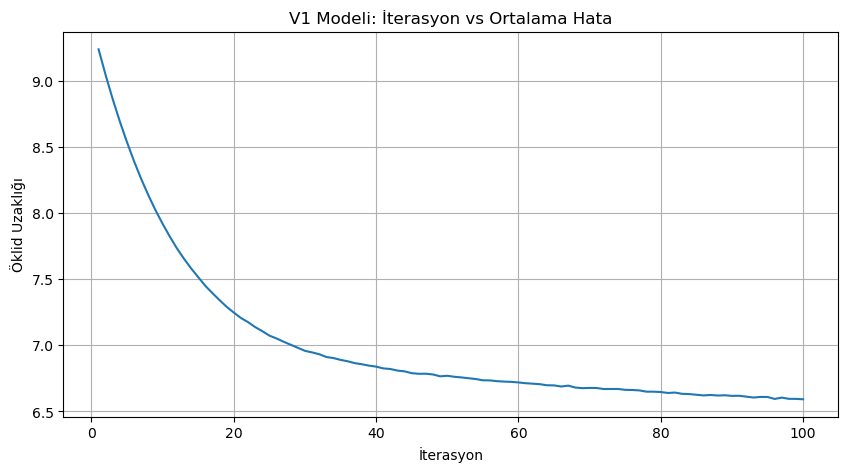

In [8]:
# Eğitim işlemi başlatılır
print("V1 modeli için öğrenme süreci başlatıldı...")
baslangic = time.time()
ornekler = X_egitim[:1000]
filtre, hata_graf = kernel_ogren(ornekler)
print(f"Öğrenme süreci tamamlandı. Toplam süre: {time.time() - baslangic:.2f} sn")

# Hata grafiği
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(hata_graf) + 1), hata_graf)
plt.title('V1 Modeli: İterasyon vs Ortalama Hata')
plt.xlabel('İterasyon')
plt.ylabel('Öklid Uzaklığı')
plt.grid(True)
plt.show()

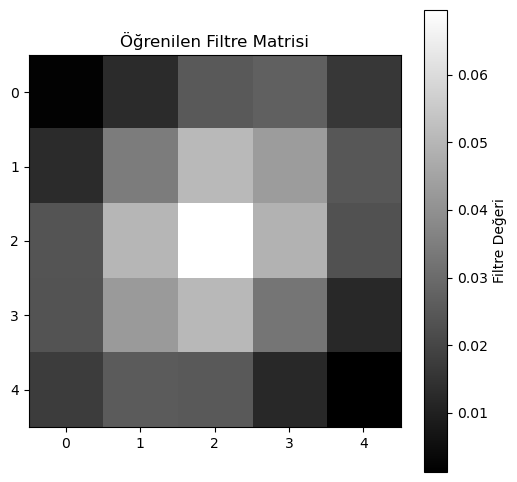

In [9]:
# Filtrenin görselleştirilmesi
plt.figure(figsize=(6, 6))
plt.imshow(filtre, cmap='gray')
plt.colorbar(label='Filtre Değeri')
plt.title('Öğrenilen Filtre Matrisi')
plt.show()

Eğitim süreci sonunda elde edilen 5x5 boyutundaki filtre matrisinin görsel incelenmesinde, çekirdeğin merkezinde daha yüksek değerlerin yer aldığı ve bu değerlerin simetrik bir şekilde kenarlara doğru azaldığı açıkça görülmektedir. Görsel olarak bu yapı, merkezde açık tonların (yüksek ağırlıklar), köşelerde ise koyu tonların (düşük ağırlıklar) baskın olduğu bir yoğunluk haritası şeklinde kendini gösterir. Bu durum, modelin filtreyi özellikle merkezi piksellere daha fazla önem verecek biçimde eğittiğini ortaya koyar. Gürültü genellikle yüksek frekanslı, rastgele ve keskin geçişler içeren bileşenlerden oluştuğundan, model bu bileşenleri bastırmak ve düşük frekanslı (daha düzgün, yapısal) bilgileri korumak amacıyla merkezi ağırlıkları öne çıkarmıştır.

Filtrenin 3B yüzey grafiği incelendiğinde ise bu yapı çok daha net biçimde ortaya çıkmaktadır. Merkezde belirgin bir tepe noktası oluşmuş, çevreye doğru ise bu yükseklik simetrik olarak azalmıştır. Elde edilen bu üç boyutlu yapı, klasik bir iki boyutlu Gauss dağılımına oldukça benzerdir. Gaussian filtreler, görüntü işlemelerinde sıkça kullanılan yumuşatma filtreleridir ve özellikle parazitlerin bastırılması için tercih edilirler. Modelin bu şekli öğrenmiş olması, modelin doğrudan formül bilgisine sahip olmadan, gürültü azaltma görevini veriye dayanarak optimal biçimde öğrendiğini göstermektedir. Sonuç olarak, öğrenilen filtre yapısı hem görsel hem de geometrik olarak düşük geçiren bir çekirdek gibi davranmakta, bu da onun Gaussian benzeri bir fonksiyonu başarıyla temsil ettiğini kanıtlamaktadır.

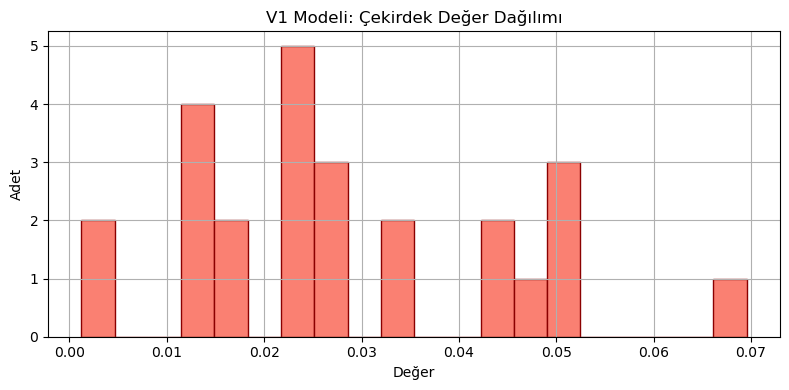

In [10]:
# Histogram: çekirdek değerlerinin dağılımı
plt.figure(figsize=(8, 4))
plt.hist(filtre.flatten(), bins=20, color='salmon', edgecolor='darkred')
plt.title('V1 Modeli: Çekirdek Değer Dağılımı')
plt.xlabel('Değer')
plt.ylabel('Adet')
plt.grid(True)
plt.tight_layout()
plt.show()

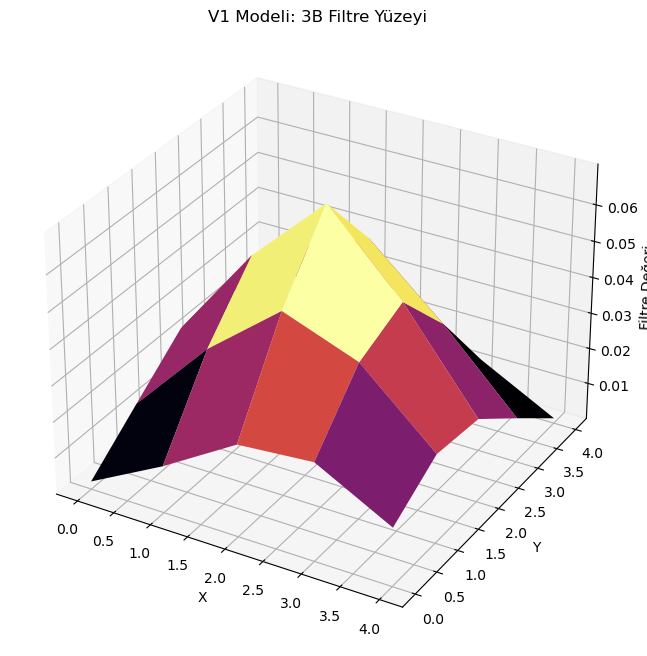

In [11]:
# 3B yüzey grafiği
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
boyut = filtre.shape[0]
x, y = np.meshgrid(np.arange(boyut), np.arange(boyut))
ax.plot_surface(x, y, filtre, cmap='inferno')
ax.set_title('V1 Modeli: 3B Filtre Yüzeyi')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Filtre Değeri')
plt.show()

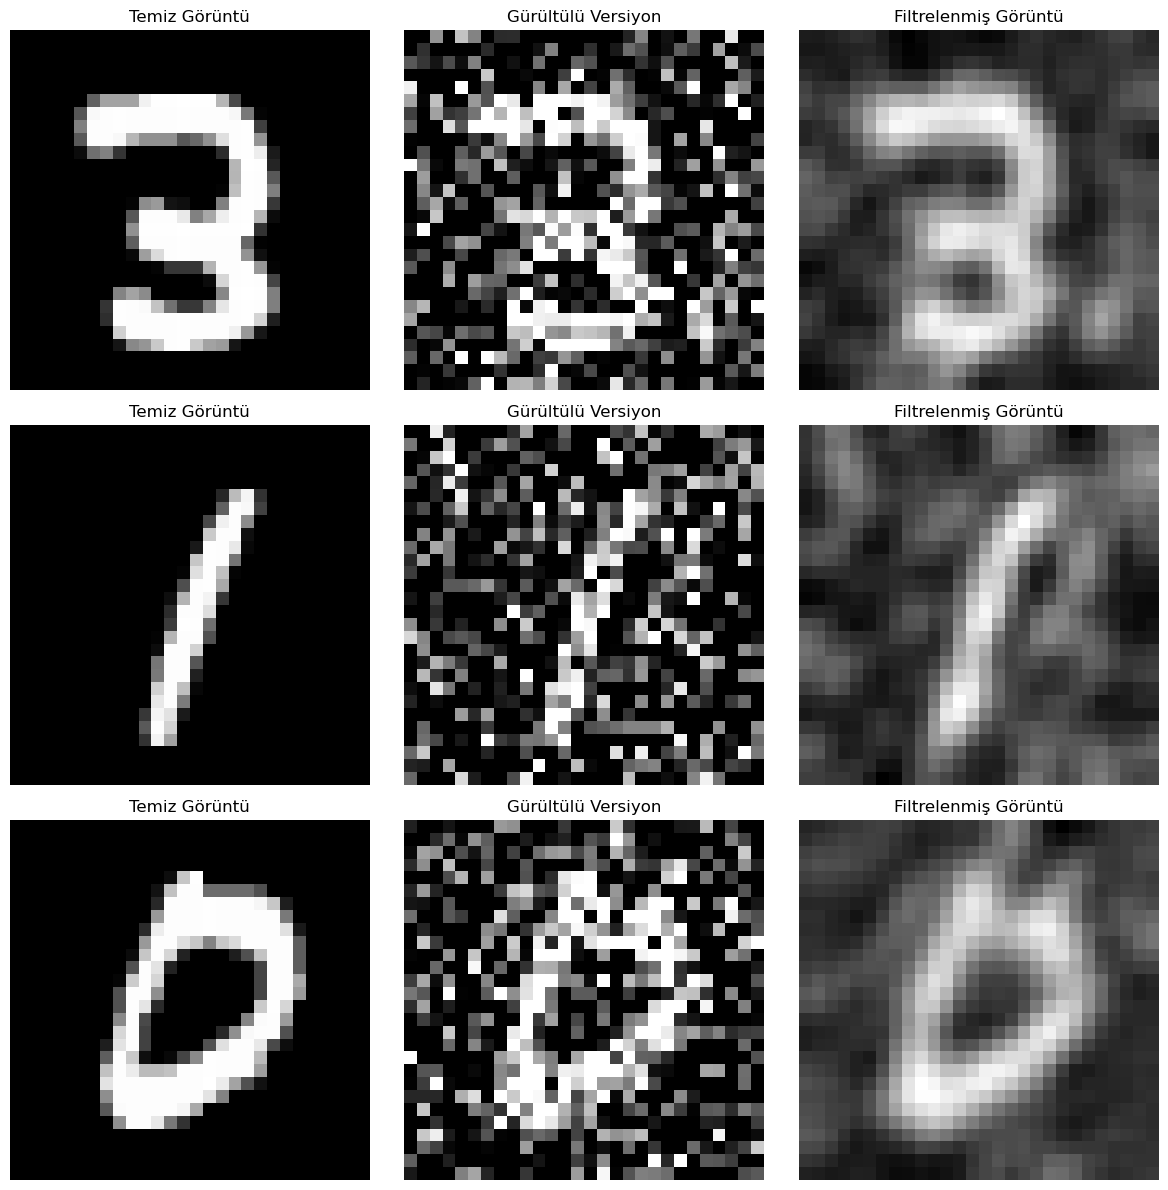

In [13]:
# Test verisi üzerinde örnek görsellerin karşılaştırması
secim = np.random.choice(len(X_test), 3, replace=False)
temiz = X_test[secim]
gurultulu = gauss_gurultu_ekle(temiz)
duzeltilmis = np.array([konvolusyon_uygula(img, filtre) for img in gurultulu])
gorsel_karsilastirma_dikey(temiz, gurultulu, duzeltilmis)